# Set-up

## Imports

In [2]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, matthews_corrcoef, PrecisionRecallDisplay

## Parameters

In [3]:
scope = 'OFF'
input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

train_years = [2018, 2019, 2020, 2021, 2022]
test_years = []

subsample_size = None

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'SolarAngle',
    'DeclAngle',
    'PVold',
    'PVnew',
    'PriceDiff',
]

features = other_features + features_to_encode

## Functions

In [4]:
def test_optimal_threshold(y_probs, y_true, plot=True):
    precision = []
    recall = []
    mcc = []
    accuracy = []
    f1 = []
    thresholds = []

    for threshold in trange(1, 100):

        y_pred = (y_probs >= threshold / 100).astype(bool)

        precision.append(precision_score(y_true, y_pred))
        recall.append(recall_score(y_true, y_pred))
        mcc.append(matthews_corrcoef(y_true, y_pred))
        accuracy.append(accuracy_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred))
        thresholds.append(threshold / 100)

    if plot:
        # Plot graph
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=thresholds, y=precision, name="Precision"))
        fig.add_trace(go.Scatter(x=thresholds, y=recall, name="Recall"))
        fig.add_trace(go.Scatter(x=thresholds, y=accuracy, name="Accuracy"))
        fig.add_trace(go.Scatter(x=thresholds, y=mcc, name="Matthews Correlation Coefficient"))
        fig.add_trace(go.Scatter(x=thresholds, y=f1, name="F1-score"))
        fig.update_layout(title="Classification performance scores depending on probability threshold",
                        xaxis_title="Classification level",
                        font=dict(family="Times New Roman, monospace", size=14, color="RebeccaPurple"),
                        template="plotly_white", width=1000, height=700)
        fig.show()

    return precision, recall, mcc, accuracy, f1, thresholds

# Main

## Preprocessing

In [5]:
input_df = pd.read_pickle(input_path)
input_df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.419,False
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.433,False
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.451,False
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,-133.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.480,False
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,-118.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.513,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,61.887169,-23.085911,holiday,Pavia,Fossil Gas,0.540,0.540,320.00,0.066,False
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,121.887169,-23.085911,holiday,Pavia,Fossil Gas,0.573,0.573,320.00,0.016,False
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,136.887169,-23.085911,holiday,Pavia,Fossil Gas,0.526,0.526,320.00,0.085,False
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,151.887169,-23.085911,holiday,Pavia,Fossil Gas,0.525,0.525,320.00,0.190,False


In [6]:
# Subsample
if subsample_size is not None:
    print(f'Subsampled {subsample_size} rows from the input dataset')
    df = input_df.sample(subsample_size)
else:
    df = input_df.copy()

print('Input dataset is composed of {} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Input dataset is composed of 3574411 observations
3.6% bids accepted in the input dataset

Training data is composed of 3574411 observations and correspond to years 2018 2019 2020 2021 2022
3.6% bids accepted in the training data

Test data is composed of 0 observations and correspond to years 
nan% bids accepted in the test data


/var/folders/q5/hqwjttz50sg2x53x_jw4yz300000gn/T/ipykernel_79169/892658936.py:19: RuntimeWarning: invalid value encountered in scalar divide
  print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))


In [7]:
input_df.unit.nunique()

131

In [76]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough"
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['hour' 'SC_PC1' 'SC_PC2' 'IN_PC1' 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP'
 'SellMGP' 'SolarAngle' 'DeclAngle' 'PVold' 'PVnew' 'PriceDiff' 'MargTech'
 'WorkDay' 'Prov' 'Tech']


## Model

# Train

In [77]:
%%time

retrain = False
save = False
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))

if retrain:
    clf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    if save:
        joblib.dump(clf, model_path)
        print(f'Model saved at {model_path}\n')

else:
    clf = joblib.load(model_path)
    print(f'Model {model_path} loaded\n')


Model BID/model_dumps/model_trained_BID_2021.joblib loaded

CPU times: user 277 ms, sys: 356 ms, total: 633 ms
Wall time: 825 ms


## Test

Average Precision Score over 333090 samples for year 2022 is: 0.5868


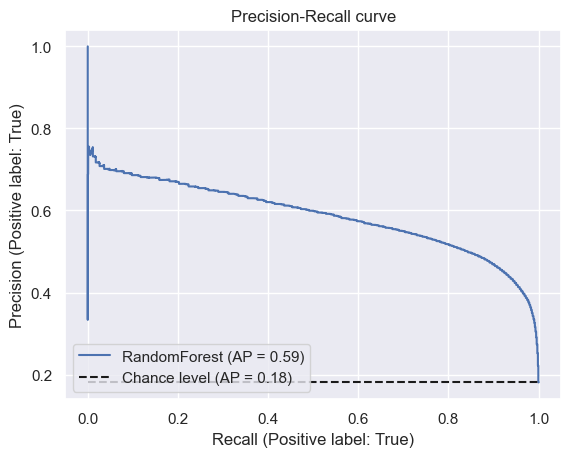

In [78]:
y_probs = pd.Series(clf.predict_proba(X_test)[:,1], index=test_df.index)

APS = average_precision_score(y_test, y_probs)

print('Average Precision Score over {} samples for year {} is: {}'.format(len(y_test), ' '.join([str(year) for year in test_years]), round(APS, 4)))

display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="RandomForest", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [79]:
y_probs.to_pickle("{}/model_predictions/RF_predicted_probs_train_{}_test_{}.pkl".format(scope, '_'.join([str(year) for year in train_years]), '_'.join([str(year) for year in test_years])))

---

# TESTS

In [40]:
input_df[['PVold', 'PVnew']].sample(20)

,PVold,PVnew
201907142UP_NPWRFRRRRB_8_BID,0.856,0.856
2019030520UP_GRAVEDONA_1_BID,0.992,0.992
201807125UP_MONFALCO_1_BID,1.000,1.000
2019062124UP_ROVESCA_1_BID,0.977,0.977
202104148UP_FUSINA_T_4_BID,1.000,1.000
2018121215UP_NPWRRVENNA_9_BID,1.000,1.000
2020102814UP_CURON_ME_1_BID,1.000,1.000
201908171UP_ETQCHIOTAS_1_BID,0.000,0.549
2021030121UP_TORVISCOSA_1_BID,1.000,1.000
202008136UP_GARGNANO_1_BID,0.000,0.570


In [ ]:
find_threshold = True

y_probs = pd.Series(clf.predict_proba(X_test)[:,1], index=test_df.index)

if find_threshold:
    precision, recall, mcc, accuracy, f1, threshold = test_optimal_threshold(y_probs, y_test)
else:
    print('No threshold search')

  0%|          | 0/99 [00:00<?, ?it/s]

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to cont